In [ ]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [ ]:
path = 'drive/MyDrive/data'
CAPUCHIN_FILE = os.path.join(path, 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join(path, 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [ ]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

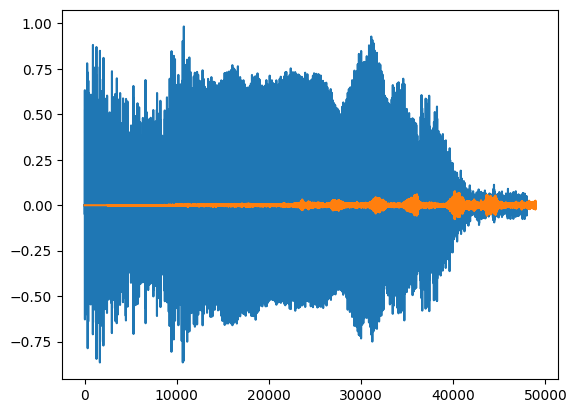

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [ ]:
POS = os.path.join(path, 'Parsed_Capuchinbird_Clips')
NEG = os.path.join(path, 'Parsed_Not_Capuchinbird_Clips')

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
lengths = []
for file in os.listdir(os.path.join(path, 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join(path, 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [ ]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [ ]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

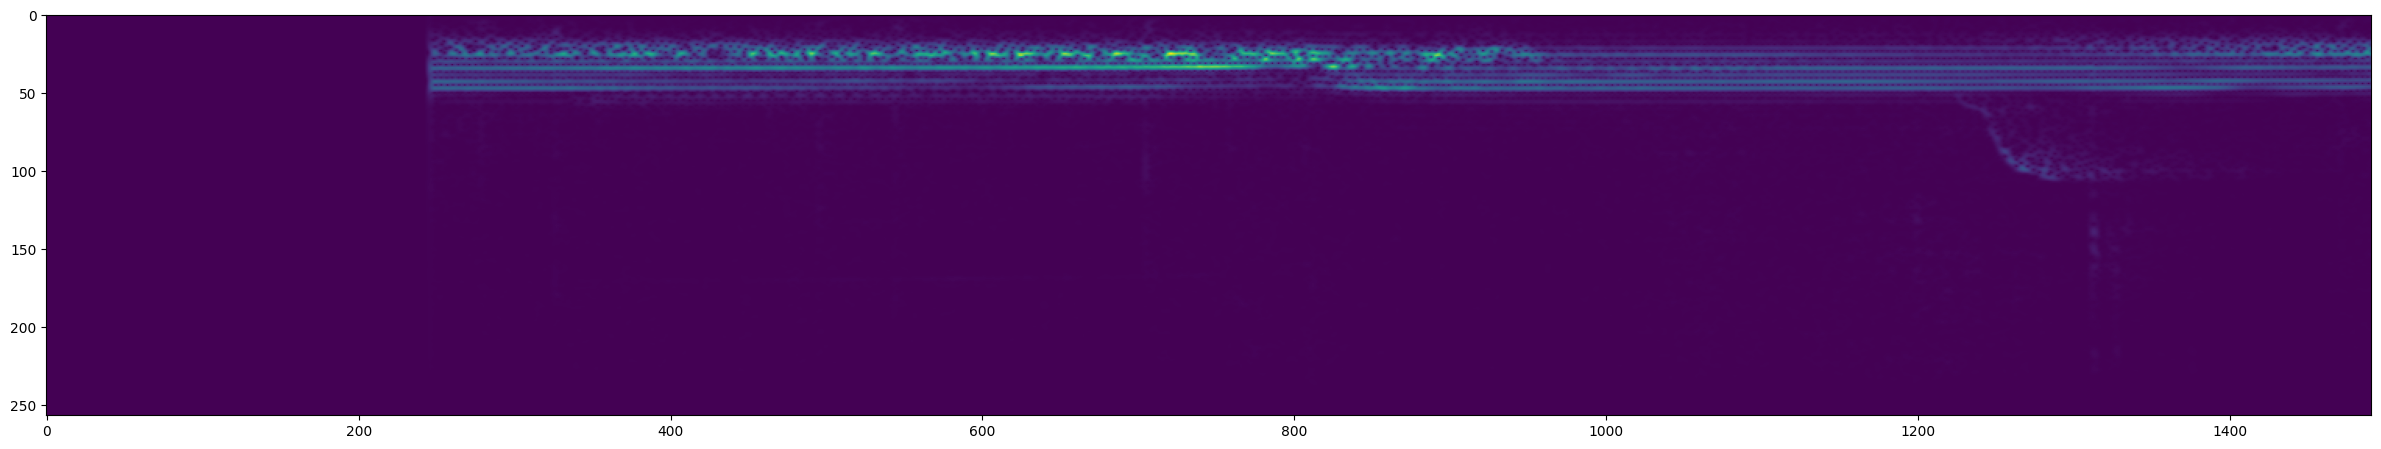

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [ ]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(8, 1491, 257, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 8)      80        
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten_1 (Flatten)         (None, 3009688)           0         
                                                                 
 dense_2 (Dense)             (None, 64)                192620096 
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 192,620,825
Trainable params: 192,620,825
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=100, validation_data=test)

Epoch 1/100
36/36 [==============================] - 6s 105ms/step - loss: 14.2838 - recall_1: 0.9032 - precision_1: 0.6222 - val_loss: 5.5254 - val_recall_1: 0.7714 - val_precision_1: 1.0000
Epoch 2/100
36/36 [==============================] - 3s 96ms/step - loss: 2.2060 - recall_1: 0.8889 - precision_1: 0.9014 - val_loss: 0.6116 - val_recall_1: 0.9444 - val_precision_1: 0.9444
Epoch 3/100
36/36 [==============================] - 3s 89ms/step - loss: 0.5334 - recall_1: 0.9875 - precision_1: 0.9405 - val_loss: 0.8112 - val_recall_1: 1.0000 - val_precision_1: 0.9615
Epoch 4/100
36/36 [==============================] - 3s 89ms/step - loss: 0.3695 - recall_1: 1.0000 - precision_1: 0.9565 - val_loss: 0.0993 - val_recall_1: 0.8788 - val_precision_1: 1.0000
Epoch 5/100
36/36 [==============================] - 3s 88ms/step - loss: 0.2992 - recall_1: 0.9459 - precision_1: 0.9859 - val_loss: 0.0471 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 6/100
36/36 [=============================